In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numba

__Define Euler–Maruyama method__

reference: [wikipedia](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method)

$dX_t = a(X_t)dt + b(X_t)dW_t$

* partition the interval [0,T] into N equal subintervals of width $\Delta t=\frac{T}{N}$:<br>
$\{\tau_0, \tau_1, ...,\tau_N\}$ = $\{0,\frac{T}{n}, \frac{2T}{n}, ..., \frac{(n-1)T}{n}, T\}$
* set $X_0=x_0$
* iterate i = 1:N:<br>
$X_{i+1} = X_i + a(X_i) \times \Delta t + b(X_i) \times (W_{i+1} - W_{i+1})$
where $W_{i+1} - W_{i+1}$ is generated by Norm$(0, \Delta t)$.


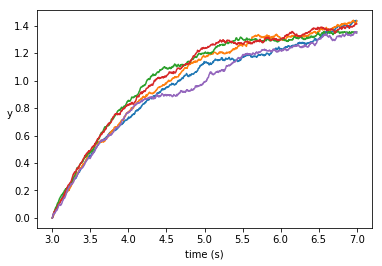

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

num_sims = 5  # Display five runs

t_init = 3
t_end  = 7
N      = 1000  # Compute 1000 grid points
dt     = float(t_end - t_init) / N
y_init = 0

c_theta = 0.7
c_mu    = 1.5
c_sigma = 0.06

def mu(y, t):
    """Implement the Ornstein–Uhlenbeck mu."""  # = \theta (\mu-Y_t)
    return c_theta * (c_mu - y)

def sigma(y, t):
    """Implement the Ornstein–Uhlenbeck sigma."""  # = \sigma
    return c_sigma

def dW(delta_t):
    """Sample a random number at each call."""
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))

ts = np.arange(t_init, t_end + dt, dt)
ys = np.zeros(N + 1)

ys[0] = y_init

for _ in range(num_sims):
    for i in range(1, ts.size):
        t = (i - 1) * dt
        y = ys[i - 1]
        ys[i] = y + mu(y, t) * dt + sigma(y, t) * dW(dt)
    plt.plot(ts, ys)

plt.xlabel("time (s)")
h = plt.ylabel("y")
h.set_rotation(0)
plt.show()

In [3]:
a = np.zeros((5, 9))

In [7]:
a[0][0] = 3
a[0][1:7] = np.array([1,2,3,4,5,6])
a

array([[3., 1., 2., 3., 4., 5., 6., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [147]:
ff = 0.98  # fraction of energy deposited in the fuel
Omega = 6.53  # MW/degree-C
M = 92.8  # MW/degree-C
mu_f = 26.3  # MW.s/degree-C
mu_c = 70.5  # MW.s/degree-C
Gr = 0.01    # this control rod reactivity [not used in this code]
alpha_c = 0.00001  # reactivity/degree-C
alpha_f = -0.00005  # reactivity/degree-C
P0a = 2500  # MW
Te = 290 # degree-C
Lambd = 0.0001
lambds = np.array([0.0124, 0.0305, 0.1110, 0.3010, 1.1400, 3.0100])
Beta = 0.006502
betas = np.array([0.000215, 0.001424, 0.001274, 0.002568, 0.000748, 0.000273])
sigma = 0.00001

n0 = 1
c0 = np.ones(6)
Th0 = Te + P0a / M
Tf0 = Th0 + ff * P0a / Omega

# self.Pc0 = 2450  # MW
Te = 290  # degree-C, inlet temperature

def dW(dt):
    #return np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
    return np.array([np.random.normal(loc=0.0, scale=np.sqrt(dt)), 0, 0, 0, 0, 0, 0, 0, 0])

def a(X):
    n = X[0]
    c = X[1:7]
    Tf = X[7]
    Th = X[8]
    rho = alpha_f * (Tf - Tf0) + alpha_c * (Th - Th0)
    
    dn = (rho - Beta) / Lambd * n + sum(betas / Lambd * c)
    dc = lambds * n - lambds * c
    dTf = (ff * P0a * n - Omega * (Tf - Th)) / mu_f
    dTh = ((1 - ff) * P0a * n + Omega * (Tf - Th) - M * (Th - Te))
    return np.concatenate((dn, dc, dTf, dTh), axis=None)

def b(X):
    n = X[0]
    return n / Lambd * sigma
    
t_init = 0
t_end  = 10
N      = 1000000
dt     = float(t_end - t_init) / N

ts = np.arange(t_init, t_end + dt, dt)
Xs = np.zeros((N + 1, 9))
Xs[0][0] = n0
Xs[0][1:7] = c0
Xs[0][7] = Tf0
Xs[0][8] = Th0

for i in range(1, ts.size):
    X = Xs[i - 1]
    Xs[i] = X + a(X) * dt + b(X) * dW(dt)


mean 0.9999575336202733
variance first half 7.499729073499845e-05
variance second half 7.553212877974903e-05


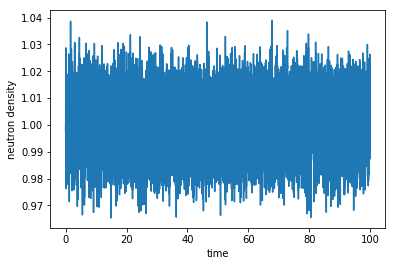

In [150]:
Nend = N
plt.plot(ts[0:Nend], Xs[0:Nend,0])
plt.xlabel('time')
plt.ylabel('neutron density')
print("mean", Xs[0:Nend,0].mean())
print("variance first half", Xs[0:int(Nend/2),0].var())
print("variance second half", Xs[int(Nend/2):,0].var())

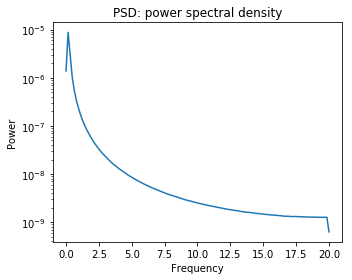

In [155]:
from scipy import signal
freqs, psd = signal.welch(Xs[0:Nend,0],fs = 40)
plt.figure(figsize=(5, 4))
plt.semilogy(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

#### vibration displacement simulation

###### under normal condition

$\ddot x+2D \dot x +\omega_0^2 x = f(t)$

Let $x_1 = x$ and $x_2 = \dot x$

$ \dot x_2 + 2D x_2 +\omega_0^2 x_1 = f(t)$

$\dot x_1 = x_2$

$ \dot x_2 =  -2D x_2 -\omega_0^2 x_1 + f(t)$

$S_{xx}(\omega)=\frac{const}{(\omega^2 - \omega_0^2)^2 + 4D^2\omega^2}$

$\omega_r = \sqrt{\omega_0^2-2D^2}$

In [198]:
# plot Sxx
omega0 = 4
omegar = 3
D = np.sqrt((omega0 ** 2 - omegar ** 2) / 2)
print(D)
omega_r = np.sqrt(omega0 ** 2 - 2 * D ** 2)
print(omega_r)
omega = np.arange(0,10,0.001)
sigma = 1000
Sxx = 1 / ((omega**2 - omega0**2)**2 + 4 * D**2 * omega **2)

1.8708286933869707
3.0


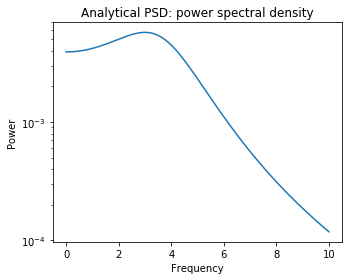

In [199]:
plt.figure(figsize=(5, 4))
plt.semilogy(omega, Sxx)
plt.title('Analytical PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

In [220]:
def dW(dt):
    #return np.array([0, 0])
    return np.array([0, np.random.normal(loc=0.0, scale=np.sqrt(dt))])

def a(X):
    x1 = X[0]
    x2 = X[1]

    
    dx1 = x2
    dx2 = -2 * D * x2 - omega0 ** 2 * x1
    
    return np.concatenate((dx1, dx2), axis=None)

def b(X):
    return 1

t_init = 0
t_end  = 100
N      = 100000
dt     = float(t_end - t_init) / N

ts = np.arange(t_init, t_end + dt, dt)
Xs = np.zeros((N + 1, 2))
Xs[0][0] = 0
Xs[0][1] = 0

for i in range(1, ts.size):
    X = Xs[i - 1]
    Xs[i] = X + a(X) * dt + b(X) * dW(dt)

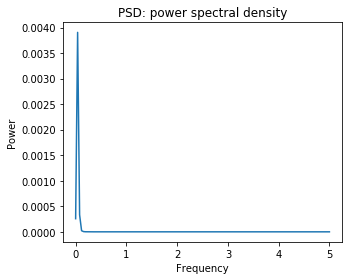

In [221]:
freqs, psd = signal.welch(Xs[0:Nend,0],fs = 10)
plt.figure(figsize=(5, 4))
plt.plot(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

mean 0.0005940083478316389
variance first half 0.008749621758205676
variance second half 0.008740441880282475


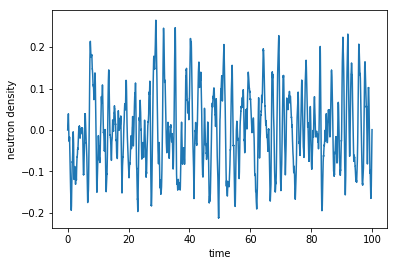

In [222]:
Nend = N
plt.plot(ts[0:Nend], Xs[0:Nend,0])
plt.xlabel('time')
plt.ylabel('neutron density')
print("mean", Xs[0:Nend,0].mean())
print("variance first half", Xs[0:int(Nend/2),0].var())
print("variance second half", Xs[int(Nend/2):,0].var())

In [228]:
def dW(dt):
    #return np.array([0, 0])
    return np.array([np.random.normal(loc=0.0, scale=np.sqrt(dt))])

def a(X):
    x1 = X[0]
    dx1 = 0    
    return dx1

def b(X):
    return 1

t_init = 0
t_end  = 100
N      = 100000
dt     = float(t_end - t_init) / N

ts = np.arange(t_init, t_end + dt, dt)
Xs = np.zeros((N + 1, 1))
Xs[0][0] = 0

for i in range(1, ts.size):
    X = Xs[i - 1]
    Xs[i] = X + a(X) * dt + b(X) * dW(dt)

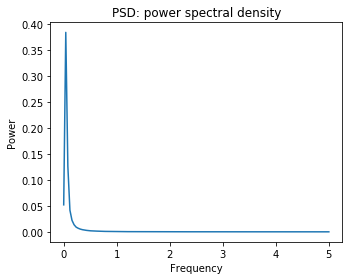

In [229]:
freqs, psd = signal.welch(Xs[0:Nend,0],fs = 10)
plt.figure(figsize=(5, 4))
plt.plot(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

mean 7.604250624490592
variance first half 3.798944783700919
variance second half 10.79124838896933


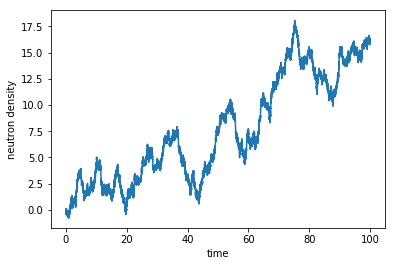

In [230]:
Nend = N
plt.plot(ts[0:Nend], Xs[0:Nend,0])
plt.xlabel('time')
plt.ylabel('neutron density')
print("mean", Xs[0:Nend,0].mean())
print("variance first half", Xs[0:int(Nend/2),0].var())
print("variance second half", Xs[int(Nend/2):,0].var())

In [226]:
Xs

array([[ 0.        ,  0.        ],
       [ 0.        , -0.05065838],
       [ 0.        ,  0.00274418],
       ...,
       [ 0.        , -0.38231662],
       [ 0.        , -0.34963114],
       [ 0.        , -0.36949849]])

In [ ]:
from scipy import signal

In [126]:
beta = 0.006019
Lambd = 0.00002
lambd = 0.15
alpha_f = -0.0000324
alpha_c = -0.000213
mu_f = 26.3
mu_c = 71.8
M = 102
Omega = 6.6
f = 0.92
sigma_rhovib = 2e-5
sigma_Ti = 0.5
P0 = 2500

n0 = 1
c0 = 1
Th0 = Te + P0 / M
Tf0 = Th0 + ff * P0 / Omega

# self.Pc0 = 2450  # MW
Te = 290  # degree-C, inlet temperature

def dW(dt):
    return np.array([np.random.normal(loc=0.0, scale=np.sqrt(dt)), 0, 0, 0])
    #return np.array([0, 0, 0, 0])

def a(X):
    n = X[0]
    c = X[1]
    Tf = X[2]
    Th = X[3]
    rho = alpha_f * (Tf - Tf0) + alpha_c * (Th - Th0)
    
    dn = (rho - beta) / Lambd * n + beta / Lambd * c
    dc = lambd * n - lambd * c
    dTf = (ff * P0a * n - Omega * (Tf - Th)) / mu_f
    dTh = ((1 - ff) * P0a * n + Omega * (Tf - Th) - M * (Th - Te))
    return np.concatenate((dn, dc, dTf, dTh), axis=None)

def b(X):
    n = X[0]
    return n / Lambd * sigma_rhovib
    
t_init = 0
t_end  = 10
N      = 1000000
dt     = float(t_end - t_init) / N

ts = np.arange(t_init, t_end + dt, dt)
Xs = np.zeros((N + 1, 4))
Xs[0][0] = n0
Xs[0][1] = c0
Xs[0][2] = Tf0
Xs[0][3] = Th0

for i in range(1, ts.size):
    X = Xs[i - 1]
    Xs[i] = X + a(X) * dt + b(X) * dW(dt)


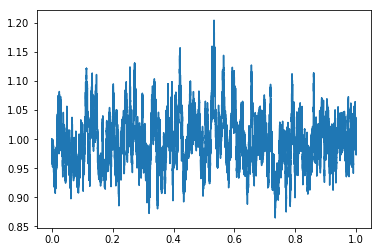

In [127]:
plt.plot(ts[0:Nend], Xs[0:Nend,0])

In [112]:
beta = 0.006019
Lambd = 0.00002
lambd = 0.15
alpha_f = -0.0000324
alpha_c = -0.000213
mu_f = 26.3
mu_c = 71.8
M = 102
Omega = 6.6
f = 0.92
sigma_rhovib = 2e-5
sigma_Ti = 0.5
P0 = 2500

dW_0 = np.array([[0.], [0.], [0.], [0.]])


A = np.array([[-beta/Lambd, beta/Lambd, alpha_f / Lambd, alpha_c / Lambd], 
              [lambd, -lambd, 0, 0], 
              [f*P0/mu_f, 0, -Omega/mu_f, Omega/mu_f], 
              [(1-f)*P0 / mu_c, 0, f*Omega/mu_c, - (Omega + 2 * M) / mu_c]])

B = np.array([[sigma_rhovib, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, M*sigma_Ti/mu_c]])

def dW(dt):
    dW_0[0] = np.random.normal(loc=0.0, scale=np.sqrt(dt))
    dW_0[1] = np.random.normal(loc=0.0, scale=np.sqrt(dt))
    dW_0[2] = np.random.normal(loc=0.0, scale=np.sqrt(dt))
    dW_0[3] = np.random.normal(loc=0.0, scale=np.sqrt(dt))
    return dW_0

t_init = 0
t_end  = 1000
N      = 1000000
dt     = float(t_end - t_init) / N

ts = np.arange(t_init, t_end + dt, dt)
Xs = np.zeros((N + 1, 4))

for i in range(1, ts.size):
    X = Xs[i - 1]
    Xs[i] = X + A.dot(X[:, None]).flatten() * dt + B.dot(dW(dt)).flatten()
    
Nend = N / 10
plt.plot(ts[0:Nend], Xs[0:Nend,0])

TypeError: slice indices must be integers or None or have an __index__ method

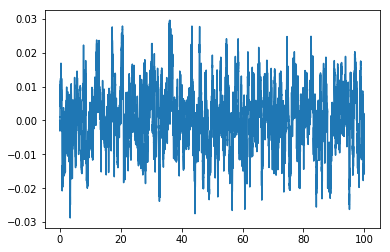

In [113]:
Nend = int(N / 10)
plt.plot(ts[0:Nend], Xs[0:Nend,0])

In [104]:
dW_0 = np.array([[0.], [0.], [0.], [0.]])
dW_0[0,:] = np.random.normal(loc=0.0, scale=np.sqrt(dt))
dW_0[1,:] = np.random.normal(loc=0.0, scale=np.sqrt(dt))
dW_0[2,:] = np.random.normal(loc=0.0, scale=np.sqrt(dt))
dW_0[3,:] = np.random.normal(loc=0.0, scale=np.sqrt(dt))

In [105]:
dW_0[1] = np.random.normal(loc=0.0, scale=np.sqrt(dt))
dW_0

array([[ 0.00359247],
       [ 0.00207034],
       [ 0.00393787],
       [-0.00170364]])

In [103]:
np.random.normal(loc=0.0, scale=np.sqrt(dt))

-0.0009565742952757681

In [87]:
dW_0

array([[0],
       [0],
       [0],
       [0]])